# Semi-synthetic Spellmatch weighting parameter sensitivity analysis - results

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

## Convergence criteria

In [4]:
scores_info = pd.read_csv("spellmatch_psa_weighting/scores.csv")
source_desc = scores_info["points_file_name"].str.split("[_\.]", regex=True)
df = pd.DataFrame(
    data={
        "is_dense": source_desc.str[0] == "dense",
        "is_heterogeneous": source_desc.str[1] == "heterogeneous",
        "use_prior": scores_info["spellmatch_alpha"] != 1.0,
        "use_degrees": scores_info["spellmatch_degree_weight"] != 0.0,
        "use_intensities": scores_info["spellmatch_intensity_weight"] != 0.0,
        "use_distances": scores_info["spellmatch_distance_weight"] != 0.0,
        "converged": scores_info["error"].isna(),
    }
)

In [5]:
remaining_cols = [col for col in df if col != "converged"]
col_order = []
scores = []
while len(remaining_cols) > 0:
    next_best_col = None
    next_best_score = -float("inf")
    for col in remaining_cols:
        x = df[col_order + [col]]
        y = df["converged"]
        estimator = LogisticRegression().fit(x, y)
        score = estimator.score(x, y)
        if score > next_best_score:
            next_best_col = col
            next_best_score = score
    col_order.append(next_best_col)
    scores.append(next_best_score)
    remaining_cols.remove(next_best_col)

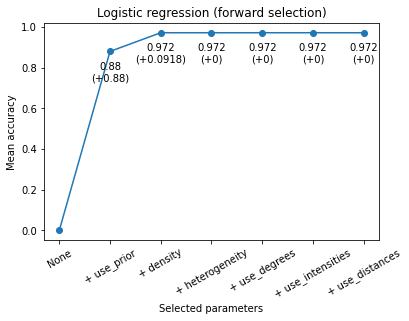

In [28]:
xs = range(len(scores) + 1)
ys = [0] + scores
col_features = {
    "is_dense": "density",
    "is_heterogeneous": "heterogeneity",
    "use_prior": "use_prior",
    "use_degrees": "use_degrees",
    "use_intensities": "use_intensities",
    "use_distances": "use_distances",
}
xtick_labels = ["None"] + [f"+ {col_features[col]}" for col in col_order]

plt.plot(xs, ys, "-o")
plt.title("Logistic regression (forward selection)")
plt.xlabel("Selected parameters")
plt.ylabel("Mean accuracy")
plt.xticks(ticks=xs, labels=xtick_labels, rotation=30)
for i, (x, y) in enumerate(zip(xs[1:], ys[1:]), start=1):
    plt.text(x, y - 0.05, f"{y:.3g}\n(+{(y - ys[i - 1]):.3g})", ha="center", va="top")
plt.show()

In [29]:
matrix = df.groupby(col_order[1::-1])["converged"].mean().to_frame(name="frac_converged")
matrix = matrix.reset_index().pivot(index="use_prior", columns="is_dense", values="frac_converged")
matrix

is_dense,False,True
use_prior,,
False,0.085938,0.867188
True,1.000000,0.997396


## Assignment strategy

In [30]:
results = pd.read_csv("spellmatch_psa_weighting/results.csv")
df = results[results["spellmatch_alpha"] != 1]

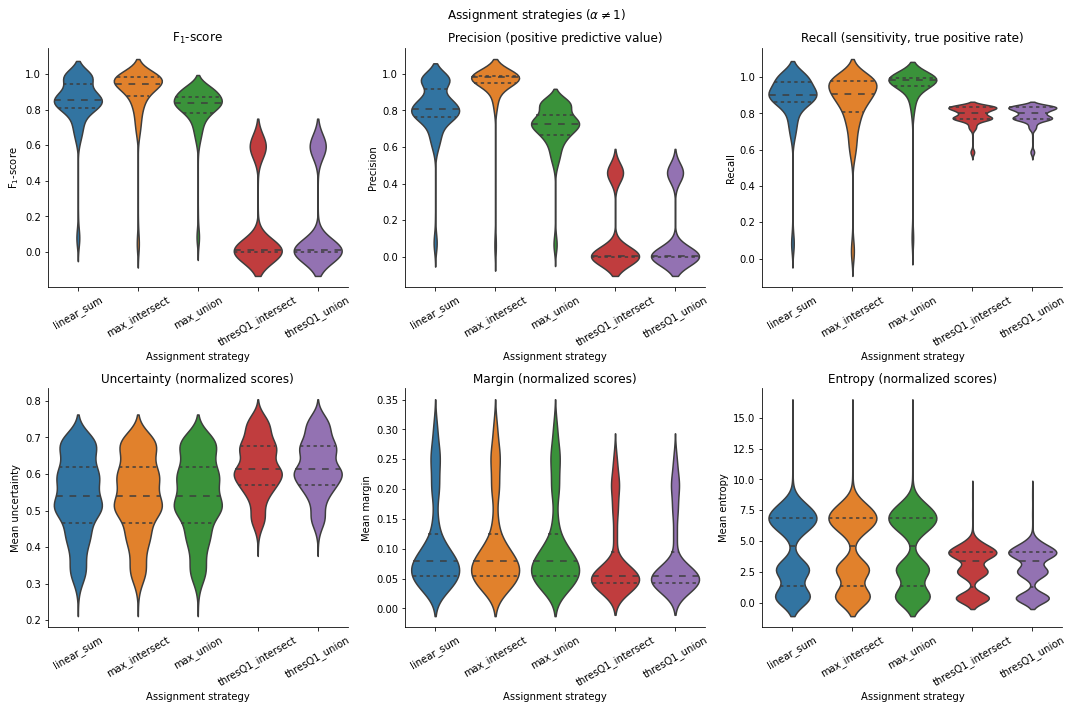

In [31]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    data=df,
    col="metric_name",
    col_wrap=3,
    col_order=["f1score","precision", "recall", "uncertainty_mean", "margin_mean", "entropy_mean"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
    "uncertainty_mean": "Uncertainty (normalized scores)",
    "margin_mean": "Margin (normalized scores)",
    "entropy_mean": "Entropy (normalized scores)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
    "uncertainty_mean": "Mean uncertainty",
    "margin_mean": "Mean margin",
    "entropy_mean": "Mean entropy",
}
g.fig.suptitle("Assignment strategies ($\\alpha \\neq 1$)")
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.tick_params(axis="x", labelbottom=True, rotation=30)
g.tight_layout()

## Parameter selection

In [32]:
results = pd.read_csv("spellmatch_psa_weighting/results.csv")
df = results[(results["spellmatch_alpha"] != 1) & (results["assignment_name"] == "linear_sum")]
df = pd.DataFrame(
    data={
        "alpha": df["spellmatch_alpha"],
        "degree_weight": df["spellmatch_degree_weight"],
        "intensity_weight": df["spellmatch_intensity_weight"],
        "distance_weight": df["spellmatch_distance_weight"],
        "metric_name": df["metric_name"].astype("category"),
        "metric_value": df["metric_value"],
    }
)
df

,alpha,degree_weight,intensity_weight,distance_weight,metric_name,metric_value
45,0.8,1.0,1.0,1.0,precision,0.742290
46,0.8,1.0,1.0,1.0,recall,0.840032
47,0.8,1.0,1.0,1.0,f1score,0.788142
48,0.8,1.0,1.0,1.0,uncertainty_mean,0.669199
49,0.8,1.0,1.0,1.0,uncertainty_std,0.049731
...,...,...,...,...,...,...
39964,0.6,0.0,0.0,0.0,uncertainty_std,0.261089
39965,0.6,0.0,0.0,0.0,margin_mean,0.233715
39966,0.6,0.0,0.0,0.0,margin_std,0.129410
39967,0.6,0.0,0.0,0.0,entropy_mean,0.489264


### Similarity weights

In [33]:
df2 = df[df["metric_name"] == "f1score"].groupby(
    ["alpha", "degree_weight", "intensity_weight", "distance_weight"]
)["metric_value"].mean().to_frame(name="f1score_mean").reset_index()

df2[["alpha", "degree_weight", "intensity_weight", "distance_weight"]].corrwith(
    df2["f1score_mean"], method="spearman"
).to_frame(name="spearman_rank_corr")

,spearman_rank_corr
alpha,0.125686
degree_weight,-0.608390
intensity_weight,0.568800
distance_weight,0.127301


$\to$ intensity_weight = 1 as "reference weight" for degree/distance weights

In [34]:
df2 = df[(df["metric_name"] == "f1score") & (df["intensity_weight"] == 1)].groupby(
    ["alpha", "degree_weight", "distance_weight"]
)["metric_value"].mean().to_frame(name="f1score_mean").reset_index()

df2[["alpha", "degree_weight", "distance_weight"]].corrwith(
    df2["f1score_mean"], method="spearman"
).to_frame(name="spearman_rank_corr")

,spearman_rank_corr
alpha,0.149188
degree_weight,-0.842019
distance_weight,-0.068599


<AxesSubplot:xlabel='degree_weight', ylabel='metric_value'>

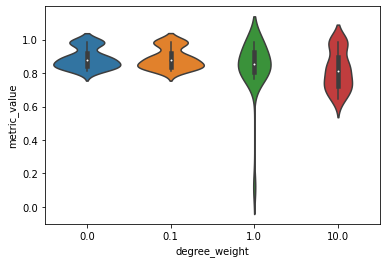

In [35]:
sns.violinplot(
    data=df[(df["metric_name"] == "f1score") & (df["intensity_weight"] == 1)],
    x="degree_weight",
    y="metric_value",
)

$\to$ degree_weight = 0

<AxesSubplot:xlabel='distance_weight', ylabel='metric_value'>

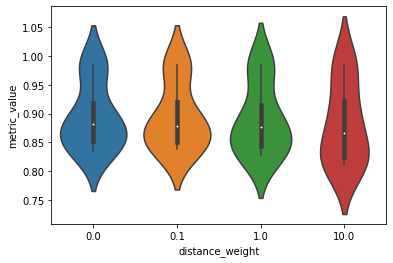

In [36]:
sns.violinplot(
    data=df[(df["metric_name"] == "f1score") & (df["intensity_weight"] == 1) & (df["degree_weight"] == 0)],
    x="distance_weight",
    y="metric_value",
)

$\to$ distance_weight = 0

### Prior weight

<AxesSubplot:xlabel='alpha', ylabel='metric_value'>

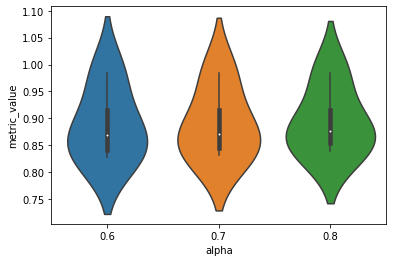

In [37]:
sns.violinplot(
    data=df[(df["metric_name"] == "f1score") & (df["intensity_weight"] == 1) & (df["degree_weight"] == 0) & (df["distance_weight"] == 1)],
    x="alpha",
    y="metric_value",
)

$\to$ alpha = 0.7